In [283]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, \
    cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
    f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

#### Dataset
 - Descarga de dataset MNIST
 - Formato datos
 - Obtención conjunto de entrenamiento y test

In [2]:
# Dataset MNIST
mnist = fetch_openml('mnist_784', version=1)
# En general, los datasets de sklearn tienen una estructura de diccionar similar
# Contiene entre otras cosas, un df de datos, una serie de etiquetas y una
# descripción del dataset
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [24]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [22]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Se convierten a arrays
X, y = np.array(X), np.array(y)
X.shape, y.shape

((70000, 784), (70000,))

In [32]:
X, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [29]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

In [34]:
some_digit.shape, some_digit_image.shape

((784,), (28, 28))

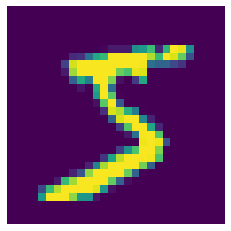

In [36]:
plt.imshow(some_digit_image)
plt.axis('off')
plt.show()

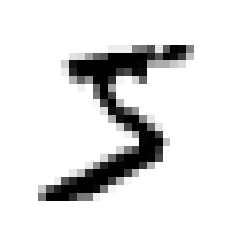

In [37]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')
plt.show()

In [38]:
y[0]

'5'

In [48]:
# Castear el array de strings a array de enteros para los algoritmos de ML
y = y.astype(np.uint8)

In [52]:
# Se crea conjunto de train y test
# MNIST ya tiene hecha la división. Las primeras 60000 corresponden con el
# conjunto train y las restantes 10000 imágenes con conjunto de test.
# El conjunto train ya está barajado, de esta manera se garantiza que
# todos los folds de la validación cruzada sean similares y que no haya algún
# fold sin alguno de los números. Además, algunos algoritmos son sensibles
# al orden de las instancias de train y funcionan mal si obtienen muchas
# instancias similares seguidas
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

#### Entrenando un clasificador binario
 - Identificar el dígito 5
 - Dos clases: 5 y no 5

In [58]:
# Obtener las etiquetas
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [60]:
# Clasificador SGD
sgd_clf = SGDClassifier(random_state=42) # semilla para reproducir resultados
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [70]:
sgd_clf.predict([some_digit])

array([ True])

#### Medidas de rendimiento
 - Accuracy con validación cruzada
 - Matriz de confusión
 - Precision y Recall
 - Balance Precision/Recall (Curva Precision/Recall)
 - Curva ROC

Accuracy con validación cruzada

In [88]:
# Implementación manual
# muestreo estratificado para que genere folds que contienen un ratio
# representativo de cada clase
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [90]:
# Implementación automática con sklearn
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [99]:
# Clasificador que predice todo ceros
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [101]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# 90% de accuracy. Solo el 10 % de las imágenes son 5.
# Accuracy por si sola no es adecuada para clasificadores, sobretodo con
# datasets sesgados (datasets desbalanceados, etc)

array([0.91125, 0.90855, 0.90915])

Matriz de confusión

In [105]:
# Pruebas con el conjunto de train
# El siguiente método, a diferencia del método anterior que devuelve la accuracy,
# devuelve las predicciones de la validación cruzada
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [144]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [114]:
len(y_train_pred)

60000

In [119]:
# cada fila representa la clase real (primera fila es la negativa)
# Cada columna representa la clase predicha (primera columna es la negativa)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [124]:
np.array([['True Negative', 'False Positive'],
         ['False Negative', 'True Positive']])

array([['True Negative', 'False Positive'],
       ['False Negative', 'True Positive']], dtype='<U14')

Precision, Recall, F1-score

- precision = TP/TP+FP

- recall = TP/TP+FN
- f1 = 2/(1/precision + 1/recall)=TP/(TP+(FN+FP/2))

In [125]:
# Precision es la accuracy de las predicciones positivas
# Precision del clasificador
# Ratio de predicciones positivas correctamente clasificadas

#Recall, sensibilidad o true positive ratio (TPR)
# Ratio de instancias positivas que son correctamente detectadas por el clasificador

In [127]:
precision_score(y_train_5, y_train_pred)
# Cuando se afirma que una imagen repesenta un 5, solo es correcto en el
# 83.7% de las veces

0.8370879772350012

In [128]:
recall_score(y_train_5, y_train_pred)
# Solo detecta el 65,1% de los 5

0.6511713705958311

In [131]:
# Gran diferencia respecto a la accuracy obtenida previamente (95%)

In [134]:
# F1-score
# Combinar precision y recall en una métrica
# Es la media harmonica. Da mucho mas peso a valores bajos.
# El clasificador tendrá un F1-score alto si precision y recall son altos
# También es útil para comparar dos clasificadores
# Favorece clasificadores que tengan precision y recal similares y no siempre
# es lo que se quiere
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [135]:
# Incrementar la precision reduce el recall y viceversa
# Encontrar balance de precision y recall

Balance Precision/Recall (Curva Precision/Recall)

In [136]:
# Si se aumenta el umbral de la función de decisión ('función de activación')
# aumenta la precision pero desciende el recall
# Si se disminuye el umbral, aumental el recall pero decae la precision

In [138]:
# sklearn no permite modificar el threshold directamente pero si a las
# a las puntuaciones que se obtienen antes de realizar la predicción final
# con el umbral seleccionado. En lugar de .predict, decision_function()
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [140]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [141]:
# Aumentar el threshold, decrece el recall. De un True positive pasa a un
# False negative
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [146]:
# ¿Qué umbral usar?

In [143]:
# Método decision_function para obtener los scores de decision en lugar de las
# predicciones
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                  method='decision_function')

In [149]:
# Se obtiene la precision y recall para todos los umbrales posibles
# Curva Precision/Recall
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [169]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

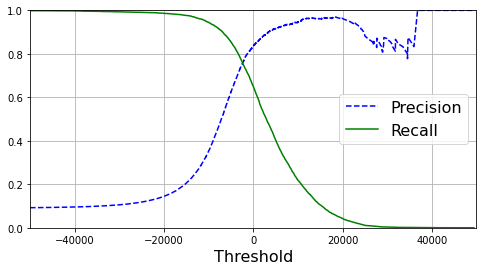

In [202]:
plt.figure(figsize=(8, 4))  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [203]:
# Se observan irregularidades en la precision. Esto se debe a que a veces cuando
# se aumenta el umbral la precision decae (en general aumenta)
# El recall solo puede decaer cuando aumental el umbral (curva mas suave)

In [210]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

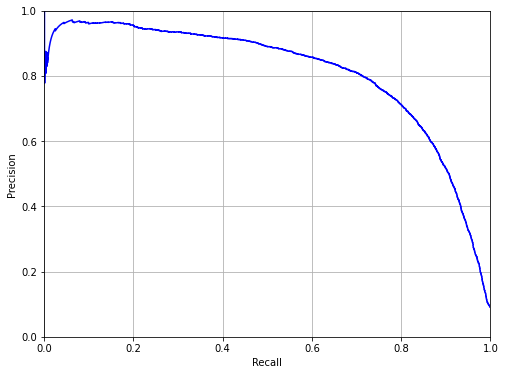

In [211]:
# Curva precision vs recall
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [212]:
# La precision empieza a decaer bruscamente alrededor del 80% del recall.
# Seleccionar un balance precision/recall antes de esta caida, en torno al 60%
# del recall, aunque este depende del proyecto

In [214]:
# Obtener predicciones si se quiere un 90% de precision
thresholds_90_precision = thresholds[np.argmax(precisions>=0.90)]
thresholds_90_precision

3370.0194991439557

In [215]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)

In [217]:
# Chequeo
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

In [218]:
# Un clasificador con una gran precision no es útil si se tiene un recall
# demasiado bajo.

Curva ROC

In [219]:
# Similar al anterior pero se grafica recall (true positive rate, sensibilidad)
# vs false positive rate (FPR).
# FPR es el ratio de instancias negativas que son clasificadas incorrectamente
# como positivas
# TNR es el ratio de instancias negativas que son clasifiicadas correctamente
# como negativas
# TNR = TN/(TN+FP) --> especifidad
# FPR = 1 - TNR = FP/(TN+FP)

In [221]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [224]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True) 

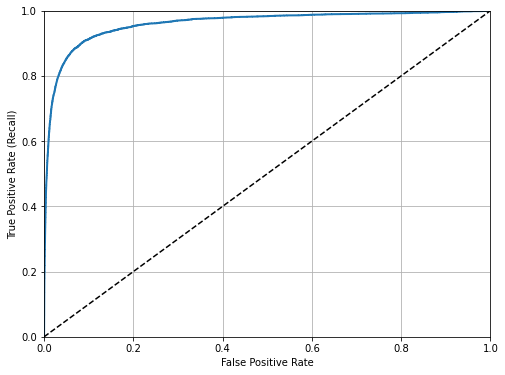

In [225]:
plt.figure(figsize=(8, 6)) 
plot_roc_curve(fpr, tpr, label=None)
plt.show()

In [226]:
# Cuanto mayor es recall, mas falsos positivos
# La línea de puntos representa la curva ROC para un clasificador aleatorio.
# Un buen clasificador tiene que estar lo mas alejado posible de esta línea
# (hacia esquina superior izquierda)

In [231]:
# ¿Cúal de las dos curvas emplear?
# Como regla general la curva de precision/recall si hay pocos ejs de la clase
# (clases desbalanceadas) positiva o cuando te importan mas los falsos positivos
# que los falsos negativos.

In [230]:
# Mirando el la curva ROC y el AUC, parece que el clasificador es bueno, pero
# se debe a que hay pocos positivos respecto a la clase negativa (no 5).
# En cambio, en la curva PR se observa que el clasificador tiene margen de
# mejora

In [228]:
# ROC AUC
# Para comparar clasificadores se puede medir el área bajo la curva (AUC)
# Un clasificador perfecto tiene un AUC igual a 1 y uno aleatorio 0.5
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [233]:
# Entrenar un clasificador random forest para comparar las curvas ROC y los AUC
# Random forest y algunos otros algoritmos no tienen el método decision_function
# De forma alternativa se tiene el método predict_proba
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                 method='predict_proba')

In [234]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [235]:
# la curva ROC necesita las etiquetas y las puntuaciones, aunque en vez de las
# puntuaciones se le puede pasar las probabilidades de clase.
# En este caso, pasar la prob. de la clase positiva como puntuación
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

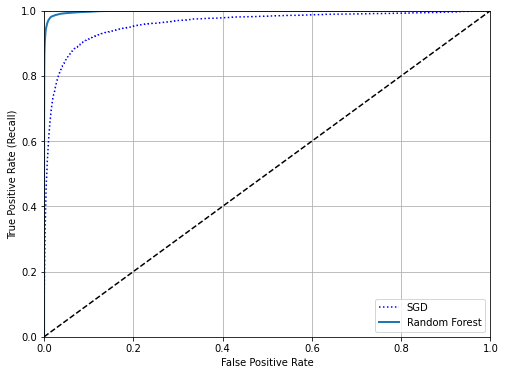

In [239]:
plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [240]:
# La curva ROC de random forest se ve mucho mas escorada a la esquina superior
# izquierda que la curva ROC de sgd (por lo tanto, mejor)

In [241]:
# El AUC tb mejora casi un 4%
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [245]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [246]:
precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(0.9905083315756169, 0.8662608374838591)

In [264]:
precision_score(y_train_5, (y_scores_forest>0.5)), recall_score(y_train_5, (y_scores_forest>0.5))

(0.9905083315756169, 0.8662608374838591)

#### Clasificación multiclase

In [265]:
# Clasificador que distingue mas de dos clases
# Clasificadores binarios (Regresión ligística, SVM)
# Clasificadores multiclase (SGD, random forest y Naive Bayes)

In [266]:
# Estrategias para llevar a cabo clasificación multiclase con clasificadores
# binarios
# - One versus the rest (OvR) o One versus all --> Entrenar un clasificador
#   binario por cada clase. Seleccionar la clase con el algoritmo que tenga
#   mayor puntuación. Ej. 10 clases, 10 clasificadores
# - One versus One (OvO) --> Entrenar un clasificador binario para cada par de
#   clases y escoger aquella clase que haya ganado mas 'duelos'. Si hay N clases,
#   es necesario entrenar N x (N-1)/2 clasificadores.
#   Ej. 10 clases, 45 clasificadores. Ventaja: El clasificador solo necesita
#   ser entrenado en la parte del dataset que contenga las dos clases.

In [267]:
# Para algunos algoritmos como SVM que escelan mal, es mas adecuado seguir una
# estrategia OvO. De esta manera se entrenan muchos clasificadores en conjuntos
# de entrenamiento pequeños. Para la mayoria de clasificadores binarios, la
# opción mas adecuada es seguir la estrategia OvR.

# sklearn detecta cuando se intenta entrenar un algoritmo de clasificación binaria
# para una tarea de clasificación multiclase y automáticamente ejecuta una de
# las dos estrategias en función del algoritmo.

In [269]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # Se le pasan las 10 clases
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [270]:
# 10 puntuaciones por instancia
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [271]:
# La clase 5 tiene la puntuación mas alta
np.argmax(some_digit_scores) # devuelve índice

5

In [272]:
# clases
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [273]:
svm_clf.classes_[5]

5

In [275]:
# Para forzar a sklearn a usar una u otra estrategia, se pueden usar las clases
# OneVsOneClassifier y OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [277]:
ovr_clf.estimators_ # ha entrenado 10 clasificadores svm

[SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]

In [278]:
# Entrenando clasificadores multiclase
# En estos clasificadores no tiene que ejecutar ninguna estrategia
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # Predice erróneamente un 3

array([3], dtype=uint8)

In [279]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [280]:
# Evaluar el modelo con accuracy en validación cruzada
# Teniendo en cuenta que un clasificador aleatorio obtiene una accuracy del 10%,
# la accuracy obtenida no está nada mal, aunque se puede mejorar.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [290]:
# Escalando las entradas mejoran las predicciones
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

#### Análisis de errores

In [293]:
# Partiendo de un modelo prometedor escogido y habiendo ajustado sus 
# hiperparámetros, se quiere mejorar su rendimiento analizando los tipos de
# errores que comete.

In [291]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

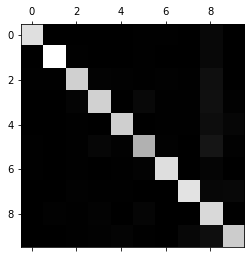

In [292]:
# Difícil ver cosas con tantos números. Representación de la matriz de confusión
# como imágen
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [294]:
# La mayoría de imágenes están en la diagonal por lo que están clasificadas 
# correctamente. La celda, en la diagonal, correspondiente a los 5 se ve
# ligeramente más oscura por lo que en esta clase no lo hace tan bien como en 
# otras.

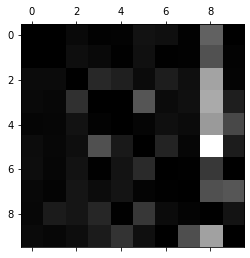

In [302]:
# Enfatizar los errores
# Dividir cada valor entre el número de imagenes en la clase correspondiente
# (comparar ratios de error en vez de números absolutos de errores)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0) # rellenar con 0s la diagonal para ver solo errores
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

In [303]:
# Se puede observar los tipos de errores que el clasificador hace.
# - Muchas imágenes de cualquiero clase fueron clasificadas como 8. La clase 8
#   clasifica bien.
# - Confunde los 3 con los 5

In [304]:
# Teniendo la información anterior se puede mejorar el clasificador con
# distintas estrategias. Esfuerzos centrados en reducir los falsos 8.
# - Recopilar más imágenes que parezcan 8 (no lo son), para que pueda aprender
#   a distinguirlos.
# - Diseñar nuevas atributos. Por ej. contando el número de bucles cerrados que
#   tienen los números.
# - Preprocesar las imágenes para destacar algunos patrones, por ej., los bucles
#   cerrados

In [308]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

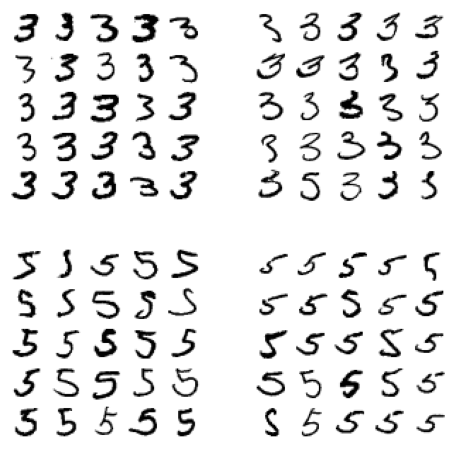

In [309]:
# También se puede analizar errores individuales. Por ej. observar los números
# 3 y 5
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [310]:
# Algunos digitos se confunden porque están mal escritos, no son claros y otros
# que se aprecian muy bien el clasificador lo hace mal. El algoritmo es lineal,
# de baja capacidad. Asigna un peso a cada pixel por clase. Como el 3 y el 5
# difieren en pocos pixeles, el sistema puede a veces confundirlos.
# La principal diferencia entre un 3 y un 5 es la línea vertical superior, ya que
# puede estar a la izquierda o la derecha. Por tanto, el clasificador es sensible
# al desplazamiento y rotación de la imágen.
# - Reducir la confusion de 3 y 5 preprocesando las imágenes para asegurarse de
#   que están centradas y no demasiado rotadas. Esto ayudará a reducir otros
#   errores (confusión entre otros números)

#### Clasificación multi-etiqueta

In [311]:
# En lugar de asignar solo una clase a cada instancia, se asignan varias clases
# por cada instancia. Ej. Reconocimiento facial, entrenado para reconocer
# caras. Si se le pasa una imagen de dos caras la salida debería ser
# [1, 0, 1] --> genera múltiples etiquetas binarias

In [312]:
y_train_large = (y_train >= 7) # Atributo: número grande o no
y_train_odd = (y_train % 2 == 1) # Atributo: número impar o no
# array con 2 etiquetas para cada instancia
y_multilabel = np.c_[y_train_large, y_train_odd]

In [314]:
knn_clf = KNeighborsClassifier() # soporta clasificación multietiqueta
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit]) # genera 2 etiquetas. El número 5 no es grande y
# es impar

array([[False,  True]])

In [315]:
# Varias formas de evaluar clasificadores multietiqueta. La métrica adecuada
# depende del proyecto.
# Por ej. medir el F1-score para cada etiqueta individual y calcular el
# promedio de la puntuación
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
# Esto asume que todas las etiquetas son igual de importantes. Si se quiere
# ponderar, cambiar el parámetro a average="weighted"

0.976410265560605

In [317]:
y_train_knn_pred

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

#### Clasificación multi-salida

In [318]:
# También llamada clasificación multisalida - multiclase
# Es una generalización de la clasificación multi-etiqueta donde cada etiqueta
# puede tener varias clases
# Por ej. sistema que elimine ruido de imágenes. Toma como entrada una imagen
# con ruido y genera una imágen limpia representada como un array de intensidades
# de pixel. La salida del clasificador es multietiquta, una etiqueta por pixel,
# y cada etiqueta puede tener múltiples valores (intensidades de pixel varían
# entre 0 y 255)

In [319]:
# Se añade ruido a las imágenes de los conjuntos de datos
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Las etiquetas son las imágenes originales
y_train_mod = X_train
y_test_mod = X_test

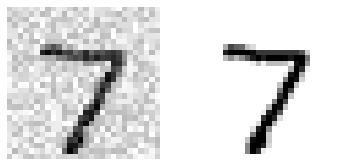

In [321]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

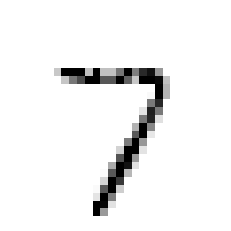

In [323]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)